In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


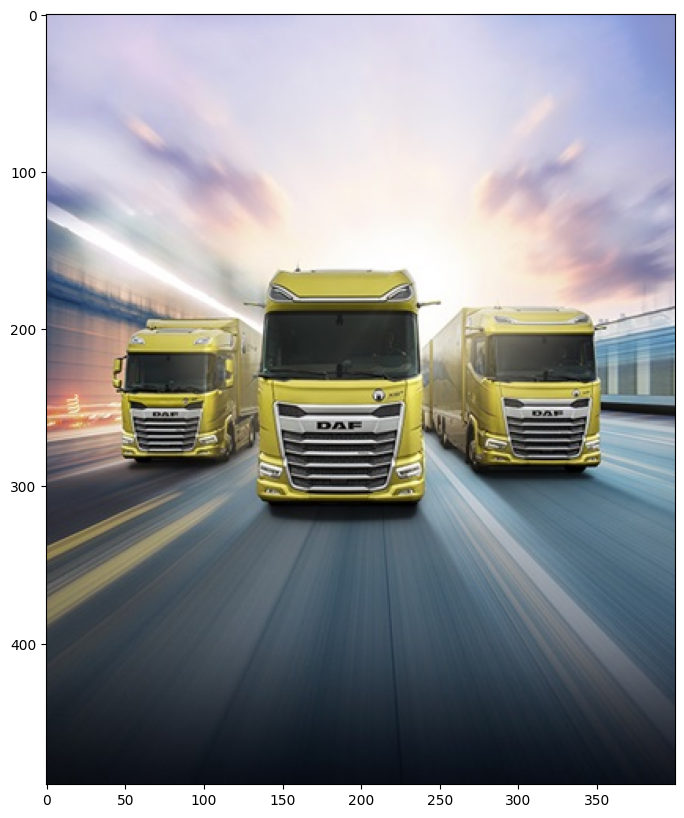

In [6]:
feature = '2'

image = cv2.imread(f'images/{feature}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()


0: 640x544 1 truck, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


cls:  tensor([7.], device='cuda:0')
truck
input_box [     132.15      161.23      243.29      313.92]


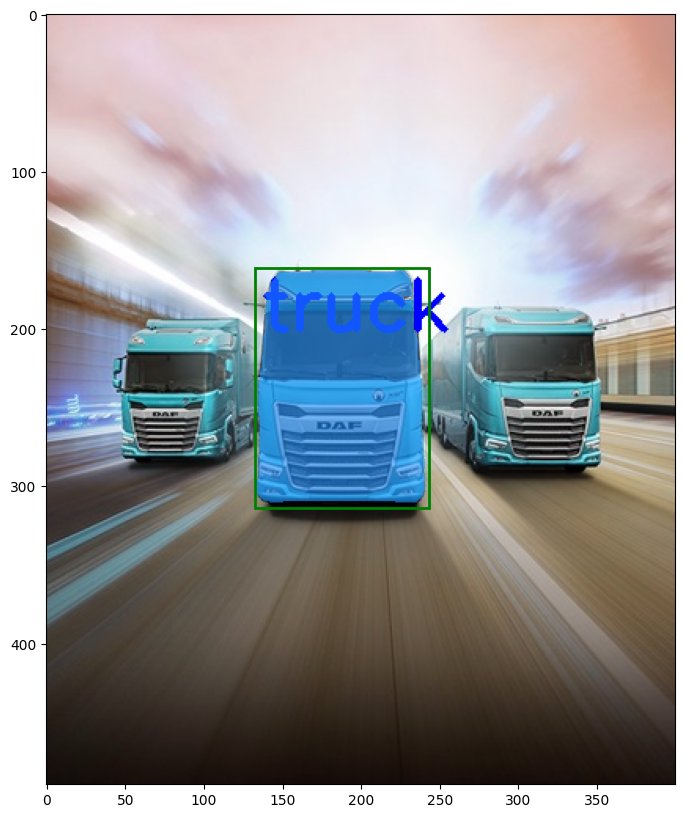

In [7]:
from ultralytics import YOLO

image = cv2.imread(f'images/{feature}.jpg')
model = YOLO('yolov8n.pt')

objects = model(image, save=True, classes=[7])

for result in objects:
    boxes = result.boxes
    # print('boxes: ', type(boxes), boxes[0].xyxy)
    cls = boxes.cls

    class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'dog']
    print('cls: ', cls)
    output_index = int(cls)
    class_name = class_names[output_index]
    print(class_name)

    if len(cls) > 0 and cls[0] == 7:
        # print('boxes :', boxes[0, :4])
        # x1, y1, x2, y2 = boxes.detach().cpu().numpy()[0, :4].tolist()
        # print(boxes[0].xyxy.detach().cpu().numpy())
        x1, y1, x2, y2 = boxes[0].xyxy.detach().cpu().numpy()[0]

        text = class_name
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.5
        thickness = 4
        text_size,_ = cv2.getTextSize(text, font, font_scale, thickness)
        text_x = int(x1 + 5)
        text_y = int(y1 + text_size[1] + 5)
        cv2.putText(image, text, (text_x, text_y), font, font_scale, (0,0,255), thickness)

        import sys
        sys.path.append("..")
        from segment_anything import sam_model_registry, SamPredictor

        sam_checkpoint = "../model/sam_vit_h_4b8939.pth"
        model_type = "vit_h"

        device = "cuda"

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        predictor = SamPredictor(sam)
        predictor.set_image(image)

        input_box = np.array(boxes[0].xyxy.detach().cpu().numpy()[0])
        print('input_box', input_box)

        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(masks[0], plt.gca())
        show_box(input_box, plt.gca())
        # plt.axis('off')
        plt.savefig('output.png')
        plt.show()